# Final Project
### Author: Maryam Zad 
### Table of Contents
1. [Data Preperation](#data-preperation)
2. [Hashtag Classification](#hashtag-classification)
3. [Merging Hashtag Labels Into User Posts](#merging-hashtag-labels-into-user-posts)
4. [Hashtag Time-Series Behavior](#hashtag-time-series-behavior)
5. [User-Level Behavior Analysis](#user-level-behavior-analysis)
6. [Exploratory Data Analysis](#exploratory-data-analysis)
7. [Modeling](#modeling)

## Data Preperation 

In [11]:
# identifying my 10000 users
# using this data 
import pandas as pd
df = pd.read_csv("user_post_summary.csv")


In [12]:
# sort by long-term presence first, then number of posts
top1000_users = df.sort_values(
    by=["days_diff", "total_posts"], 
    ascending=False
).head(10000)




In [13]:
# now grabbing the posts from the original big data set for only these users
selected_usernames = set(top1000_users["username"])
import json

filtered_posts = []

with open("all_posts_chronological_v2.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        post = json.loads(line)

        
        user = post.get("username")

        if user in selected_usernames:
            filtered_posts.append(post)

In [14]:
len(filtered_posts)

597071

In [15]:
import pandas as pd

filtered_posts_df = pd.DataFrame(filtered_posts)



In [16]:
filtered_posts_df["create_dt"] = pd.to_datetime(
    filtered_posts_df["create_time"],
    unit="s",
    utc=True,
    errors="coerce"
)

In [17]:
filtered_posts_df["date"] = filtered_posts_df["create_dt"].dt.date

In [18]:

import pandas as pd

df_tags = filtered_posts_df.copy()

# explode into one hashtag per row
df_tags = df_tags.explode("hashtag_names")

# clean hashtag text
df_tags["hashtag"] = (
    df_tags["hashtag_names"].astype(str)
    .str.strip()
    .str.lstrip("#")
    .str.lower()
)

# drop blanks
df_tags = df_tags[df_tags["hashtag"].notna() & (df_tags["hashtag"] != "")]

In [19]:
# creating the same df structure as the one professor created for hashtags with more than 30 users 
# daily date for unique_days
df_tags["date"] = df_tags["create_dt"].dt.date

hashtag_meta = (
    df_tags.groupby("hashtag")
    .agg(
        hashtag_frequency=("hashtag", "size"),
        nr_unique_users=("username", "nunique"),
        first_encountered=("create_dt", "min"),
        last_encountered=("create_dt", "max"),
        unique_days=("date", "nunique"),
    )
    .reset_index()
)

# add duration_days 
hashtag_meta["duration_days"] = (
    (hashtag_meta["last_encountered"] - hashtag_meta["first_encountered"])
    .dt.days
)

In [20]:
# excluding #sahm because its in evrey post
hashtag_meta = hashtag_meta[hashtag_meta["hashtag"] != "sahm"]
hashtag_meta = hashtag_meta[hashtag_meta["hashtag_frequency"] >= 30]

In [21]:
len(hashtag_meta)

13470

## Hashtag Classification

In [22]:
# computing thresholds 75th and 25th percentiles 
p75_unique = hashtag_meta["unique_days"].quantile(0.75)
p25_unique = hashtag_meta["unique_days"].quantile(0.25)

p75_duration = hashtag_meta["duration_days"].quantile(0.75)
p25_duration = hashtag_meta["duration_days"].quantile(0.25)


In [23]:
def classify_hashtag(row):
    if row["unique_days"] >= p75_unique and row["duration_days"] >= p75_duration:
        return "persistent"
    elif row["unique_days"] <= p25_unique or row["duration_days"] <= p25_duration:
        return "trendy"
    else:
        return "moderate"

hashtag_meta["hashtag_category"] = hashtag_meta.apply(classify_hashtag, axis=1)


In [24]:
# getting most popular hashtags from each category 
persistent_examples = (
    hashtag_meta[hashtag_meta["hashtag_category"] == "persistent"]
    .sort_values("hashtag_frequency", ascending=False)
    ["hashtag"]
    .head(5)
    .tolist()
)

moderate_examples = (
    hashtag_meta[hashtag_meta["hashtag_category"] == "moderate"]
    .sort_values("hashtag_frequency", ascending=False)
    ["hashtag"]
    .head(5)
    .tolist()
)

trendy_examples = (
    hashtag_meta[hashtag_meta["hashtag_category"] == "trendy"]
    .sort_values("hashtag_frequency", ascending=False)
    ["hashtag"]
    .head(5)
    .tolist()
)

persistent_examples, moderate_examples, trendy_examples


(['momsoftiktok', 'fyp', 'momlife', 'momtok', 'sahmlife'],
 ['sahmsoftiktok', 'sahmtok', 'capcut', 'babytok', 'momsunder25'],
 ['creatorsearchinsights',
  'onthisday',
  'over25club',
  'retokfornature',
  'memecut'])

## Merging Hashtag Labels Into User Posts 

In [25]:
df_expanded = filtered_posts_df.explode("hashtag_names")

df_expanded = df_expanded.merge(
    hashtag_meta[["hashtag", "hashtag_category", "hashtag_frequency"]],
    left_on="hashtag_names",
    right_on="hashtag",
    how="left"
)


## Hashtag Time-Series Behavior

In [26]:
top_persistent = (
    df_expanded[df_expanded["hashtag_category"] == "persistent"]
    .drop_duplicates("hashtag")
    .sort_values("hashtag_frequency", ascending=False)
    .head(5)["hashtag"]
    .tolist()
)


In [27]:
top_persistent

['momsoftiktok', 'fyp', 'momlife', 'momtok', 'sahmlife']

In [28]:
tag = top_persistent[0]

In [29]:
ts = (
    df_expanded[df_expanded["hashtag"] == tag]
    .groupby("date")
    .size()
)

full_range = pd.date_range(
    df_expanded["date"].min(),
    df_expanded["date"].max(),
    freq="D"
)

ts = ts.reindex(full_range, fill_value=0)


In [30]:
from scipy.signal import find_peaks
import numpy as np

height_thresh = np.percentile(ts, 95)  # top 5% of activity
peaks, _ = find_peaks(ts.values, height=height_thresh)


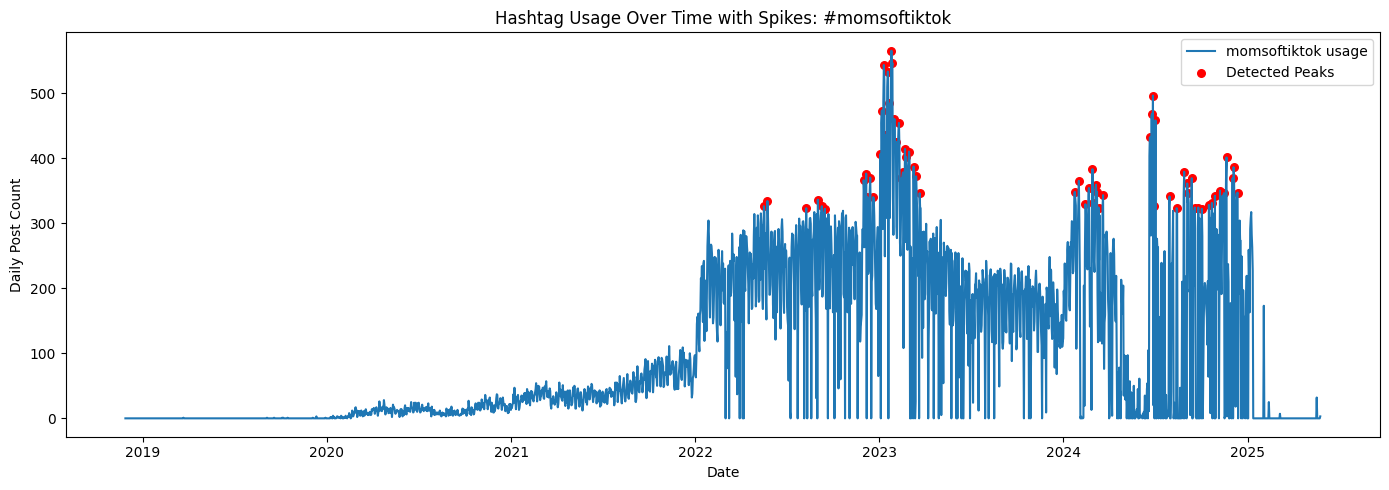

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(ts.index, ts.values, label=f"{tag} usage")
plt.scatter(ts.index[peaks], ts.values[peaks],
            color="red", s=30, label="Detected Peaks")

plt.title(f"Hashtag Usage Over Time with Spikes: #{tag}")
plt.xlabel("Date")
plt.ylabel("Daily Post Count")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
trendy = (
    df_expanded[df_expanded["hashtag_category"] == "trendy"]
    .drop_duplicates("hashtag")
    ["hashtag"]
    .tolist()
)


In [33]:
trendy

['nopainnogain',
 'yuck',
 'lovethis',
 'important',
 'sofun',
 'dvsurvivor',
 'waterslide',
 'everytime',
 'overtime',
 'cheater',
 'beardeddragon',
 'cna',
 'hannahmontana',
 'ope',
 'hurricaneprep',
 'tiktoklover',
 'cheerleader',
 'saveme',
 'momchallenge',
 'diyhair',
 '4thbaby',
 'closettour',
 'thisishalloween',
 'holidayszn',
 'yeah',
 'youshouldknow',
 'bleach',
 'heyyall',
 'spam',
 'theworst',
 'friendsgiving',
 'makemoneyathome',
 'momjuice',
 'momof3girls',
 'greenhair',
 'bossmama',
 'abcs',
 'morph',
 'sotrue',
 'dontjudgeme',
 'easymoney',
 'mickeymouseclubhouse',
 'thisisus',
 'momsuv',
 'oldest',
 'lifeishard',
 'imold',
 'momissues',
 'mommyoffour',
 'lazysunday',
 'goodthing',
 'mysonshowedmethisapp',
 'follwme',
 'pushlike',
 'cover',
 'parody',
 'loud',
 'ninja',
 'retired',
 'makethisgoviral',
 'munchies',
 'socialmediamanager',
 'girlbye',
 'getitgirl',
 'callingallmoms',
 'momdance',
 'kidscomedy',
 'largefamilymom',
 'halfwaythere',
 'workfromhomemoms',
 'epox

In [34]:
tag = 'happyeaster'

In [35]:
ts = (
    df_expanded[df_expanded["hashtag"] == tag]
    .groupby("date")
    .size()
)

full_range = pd.date_range(
    df_expanded["date"].min(),
    df_expanded["date"].max(),
    freq="D"
)

ts = ts.reindex(full_range, fill_value=0)


In [36]:
from scipy.signal import find_peaks
import numpy as np

height_thresh = np.percentile(ts, 95)  # top 5% of activity
peaks, _ = find_peaks(ts.values, height=height_thresh)


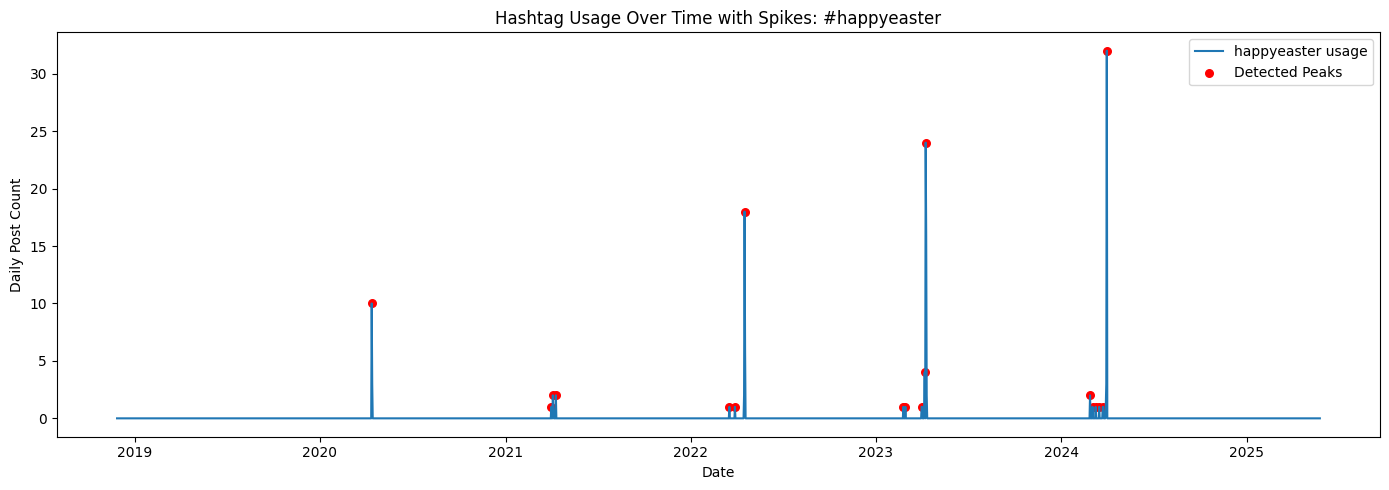

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(ts.index, ts.values, label=f"{tag} usage")
plt.scatter(ts.index[peaks], ts.values[peaks],
            color="red", s=30, label="Detected Peaks")

plt.title(f"Hashtag Usage Over Time with Spikes: #{tag}")
plt.xlabel("Date")
plt.ylabel("Daily Post Count")
plt.legend()
plt.tight_layout()
plt.show()


## User-Level Behavior Analysis

In [39]:
# computing per-user hashtag usage patterns 
user_summary = (
    df_expanded.groupby("username")["hashtag_category"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)




In [40]:
# collapse to one row per post (avoid double-counting)
post_level = (
    df_expanded
    .groupby(["id", "username"], as_index=False)
    .agg({
        "view_count": "first",
        "like_count": "first",
        "share_count": "first",
        "comment_count": "first"
    })
)

In [41]:
# computing enaggemnt per user 
user_engagement = (
    post_level
    .groupby("username")
    .agg(
        n_posts=("id", "nunique"),
        avg_views=("view_count", "mean"),
        median_views=("view_count", "median"),
        total_views=("view_count", "sum"),
        avg_likes=("like_count", "mean"),
        total_likes=("like_count", "sum")
    )
)

In [42]:
# merging hashtag behavior with user engagemnt
user_profile = user_summary.merge(
    user_engagement,
    left_index=True,   
    right_index=True,  
    how="left"
)



## Exploratory Data Analysis 

In [43]:
# correlation between usage of trendy hashtags and views 
user_profile[["trendy", "avg_views"]].corr()

,trendy,avg_views
trendy,1.000000,-0.008692
avg_views,-0.008692,1.000000


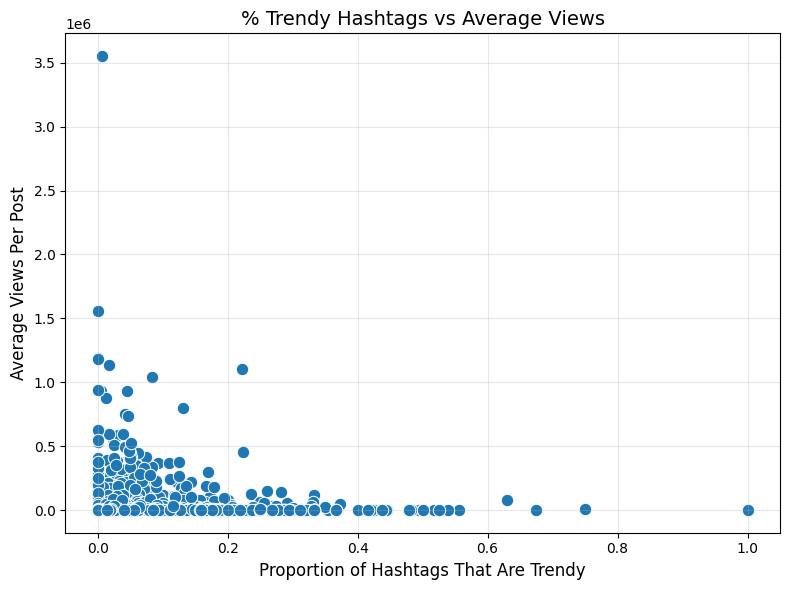

In [44]:
# scatterplot for % trendy vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="trendy",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Trendy Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Trendy", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# correlation between usage of persistent hashtags and views 
user_profile[["persistent", "avg_views"]].corr()

,persistent,avg_views
persistent,1.000000,0.020732
avg_views,0.020732,1.000000


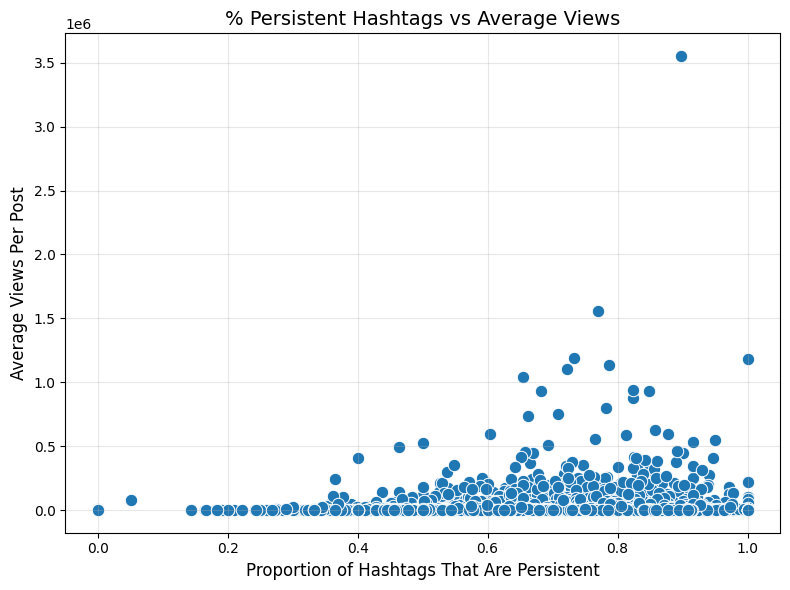

In [46]:
# scatterplot for % persistent vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="persistent",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Persistent Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Persistent", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
# correlation between usage of moderate hashtags and views 
user_profile[["moderate", "avg_views"]].corr()

,moderate,avg_views
moderate,1.000000,-0.019706
avg_views,-0.019706,1.000000


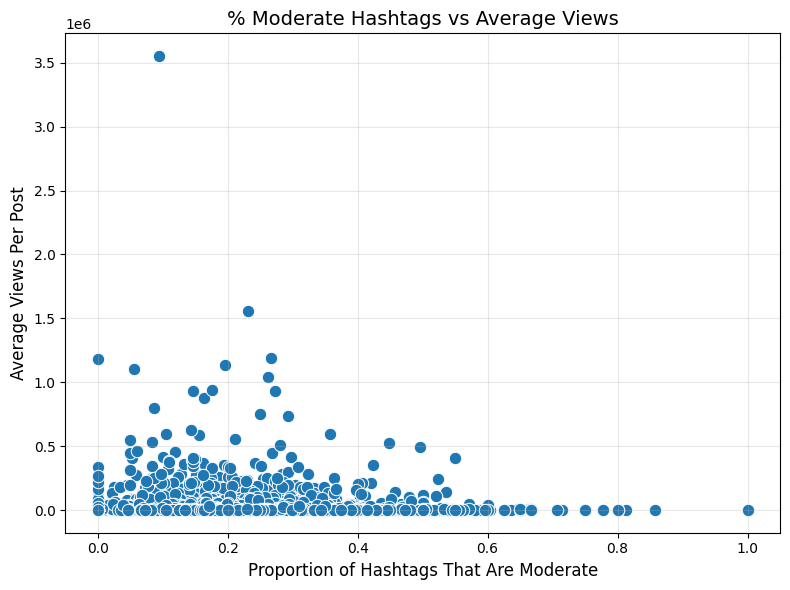

In [48]:
# scatterplot for % moderate vs avergae views 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=user_profile,
    x="moderate",          # % trendy hashtags
    y="avg_views",       # average views
    s=80
)

plt.title("% Moderate Hashtags vs Average Views", fontsize=14)
plt.xlabel("Proportion of Hashtags That Are Moderate", fontsize=12)
plt.ylabel("Average Views Per Post", fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# comparing high view users versus low view users 
median_cutoff = user_profile["avg_views"].median()
high = user_profile[user_profile["avg_views"] > median_cutoff]
low  = user_profile[user_profile["avg_views"] <= median_cutoff]

high["trendy"].mean(), low["trendy"].mean()

(np.float64(0.04933797701071896), np.float64(0.04977071932512988))

In [50]:
high["persistent"].mean(), low["persistent"].mean()

(np.float64(0.7341730470165296), np.float64(0.7384815377820089))

In [51]:
# summary of hashtag behavior for low vs high view users
compare_df = pd.DataFrame({
    "avg_trendy": [high["trendy"].mean(), low["trendy"].mean()],
    "avg_persistent": [high["persistent"].mean(), low["persistent"].mean()],
    "avg_moderate": [high["moderate"].mean(), low["moderate"].mean()]
}, index=["High-View Users", "Low-View Users"])

compare_df

,avg_trendy,avg_persistent,avg_moderate
High-View Users,0.049338,0.734173,0.216489
Low-View Users,0.049771,0.738482,0.211748


## Modeling  

In [52]:
# tree classifier 
hashtag_model_df = hashtag_meta.copy()

X = hashtag_model_df[["unique_days", "duration_days", "hashtag_frequency", "nr_unique_users"]]
y = hashtag_model_df["hashtag_category"]

In [53]:
# training the decesion tree 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [54]:
# feature importance 
import pandas as pd

importance = pd.DataFrame({
    "feature": X.columns,
    "importance": dt.feature_importances_
})
importance

,feature,importance
0,unique_days,0.547329
1,duration_days,0.452671
2,hashtag_frequency,0.000000
3,nr_unique_users,0.000000


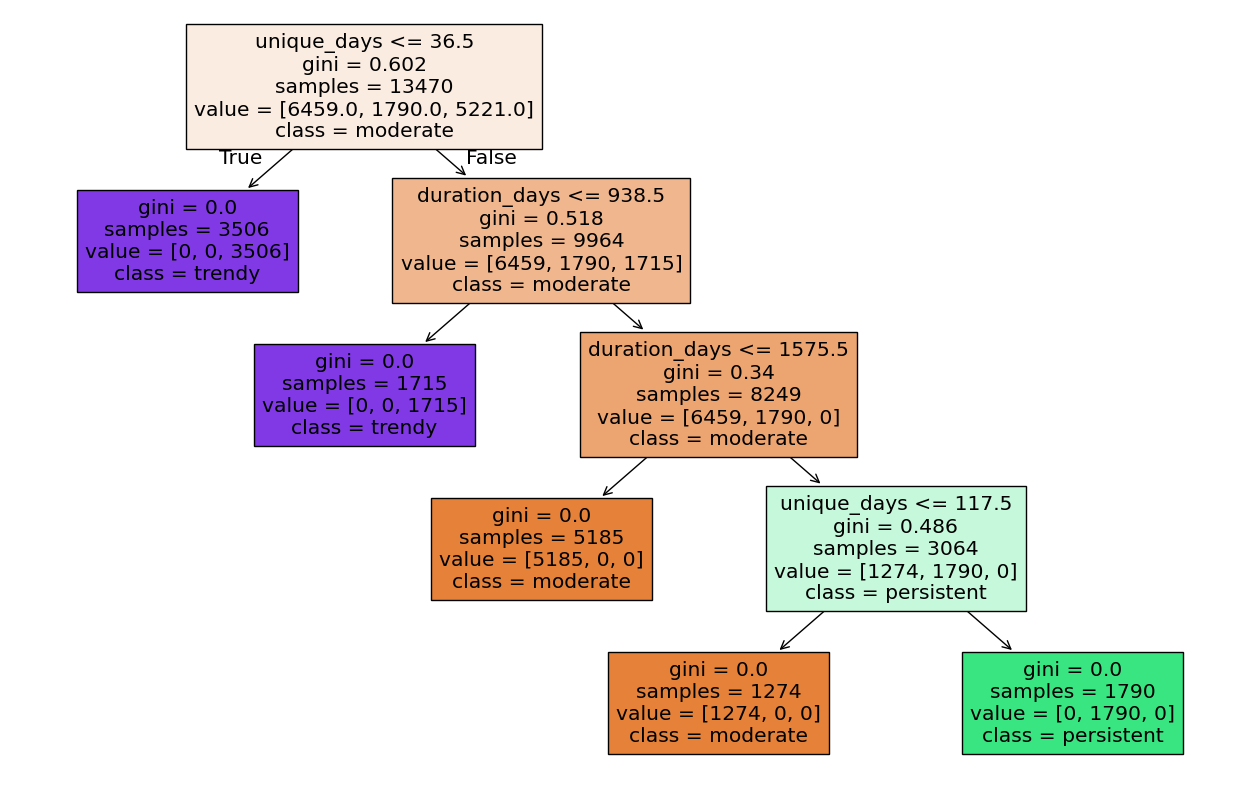

In [55]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
tree.plot_tree(dt, feature_names=X.columns, class_names=dt.classes_, filled=True)
plt.show()

### Regression

In [56]:
# computing the number of trending, persistent, and moderate hashtags per post
post_level = (
    df_expanded
    .groupby(["id", "username"], as_index=False)
    .agg(
        view_count=("view_count", "first"),
        like_count=("like_count", "first"),
        share_count=("share_count", "first"),
        comment_count=("comment_count", "first"),
        n_trendy=("hashtag_category", lambda x: (x == "trendy").sum()),
        n_persistent=("hashtag_category", lambda x: (x == "persistent").sum()),
        n_moderate=("hashtag_category", lambda x: (x == "moderate").sum()),
        total_hashtags=("hashtag_category", "count")
    )
)


In [57]:
# calculating the proportion of each hashtag category within each individual post 
post_level["pct_trendy"] = post_level["n_trendy"] / post_level["total_hashtags"]
post_level["pct_persistent"] = post_level["n_persistent"] / post_level["total_hashtags"]
post_level["pct_moderate"] = post_level["n_moderate"] / post_level["total_hashtags"]

In [60]:
# logging views because they are skewed 
import numpy as np
import statsmodels.formula.api as smf

post_level["log_views"] = np.log1p(post_level["view_count"])

In [61]:
import statsmodels.formula.api as smf
# fitting the model 
model = smf.ols(
    "log_views ~ pct_trendy + pct_persistent + pct_moderate",
    data=post_level
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     262.3
Date:                Thu, 18 Dec 2025   Prob (F-statistic):          3.91e-170
Time:                        19:31:10   Log-Likelihood:            -1.1761e+06
No. Observations:              593297   AIC:                         2.352e+06
Df Residuals:                  593293   BIC:                         2.352e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.572e+09    2.8e+09      0.

In [62]:
post_level["log_views_dm"] = (
    post_level["log_views"]
    - post_level.groupby("username")["log_views"].transform("mean")
)

post_level["pct_trendy_dm"] = (
    post_level["pct_trendy"]
    - post_level.groupby("username")["pct_trendy"].transform("mean")
)

post_level["pct_persistent_dm"] = (
    post_level["pct_persistent"]
    - post_level.groupby("username")["pct_persistent"].transform("mean")
)

post_level["pct_moderate_dm"] = (
    post_level["pct_moderate"]
    - post_level.groupby("username")["pct_moderate"].transform("mean")
)


In [63]:
# adding user fixed effects
model_fe = smf.ols(
    "log_views_dm ~ pct_trendy_dm + pct_persistent_dm + pct_moderate_dm",
    data=post_level
).fit()
print(model_fe.summary())



                            OLS Regression Results                            
Dep. Variable:           log_views_dm   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     460.0
Date:                Thu, 18 Dec 2025   Prob (F-statistic):          1.43e-298
Time:                        19:31:22   Log-Likelihood:            -9.4759e+05
No. Observations:              593297   AIC:                         1.895e+06
Df Residuals:                  593293   BIC:                         1.895e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0007      0.00